# A Supervised Machine Learning Model for Classification of Canadian Cheeses

# Introduction

## Objective

The goal of this project is to develop a supervised machine learning model to predict whether a cheese is lower-fat or higher-fat, given data on the cheese's milk type and moisture content. As the objective is to predict a binary categorical variable, this is a problem of classification rather than regression. 

The expected outcome is that the model can accurately classify cheeses as lower-fat or higher-fat based on the two aforementioned variables, which would be of value to cheese producers, distributors, and retailers in labeling cheeses correctly. This would allow for more efficient development of marketing strategies and better catering to consumer preferences and dietary needs.

# Exploratory Data Analysis

## Reading and Splitting Data
To begin, I import the required libraries, then I read the data from a .csv file and print the first 5 rows of the data frame.

In [1]:
# import necesesary libraries
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# read in data
cheese = pd.read_csv("data/cheese_data.csv")

# view columns and their data types
cheese.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


Table 1: The first 5 rows of the imported dataset

\
Then, I filter the dataframe to include only the columns of interest, then print the first 5 rows again.

In [3]:
# filter feature and target columns
cheese = cheese.loc[:, ["MoisturePercent", "MilkTypeEn", "FatLevel"]]
cheese.head()

,MoisturePercent,MilkTypeEn,FatLevel
0,47.0,Ewe,lower fat
1,47.9,Cow,lower fat
2,54.0,Cow,lower fat
3,47.0,Cow,lower fat
4,49.4,Cow,lower fat


Table 2: The first 5 rows of the dataset, filtered for columns of interest

\
I split the data frame into a train and test set, using an 80/20 train to test split. 

In [4]:
cheese_train, cheese_test = train_test_split(cheese, train_size=0.80)

\
Next, I would like to know the data types of each column in the training data frame.

In [5]:
# return dtypes of train data frame
cheese_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 81 to 515
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MoisturePercent  821 non-null    float64
 1   MilkTypeEn       832 non-null    object 
 2   FatLevel         833 non-null    object 
dtypes: float64(1), object(2)
memory usage: 26.0+ KB


\
I would like to know more about the values in the **MoisturePercent** column, and the categories in the **MilkTypeEn** and **FatLevel** columns in the training data frame. \
To do this, I print summary statistics for **MoisturePercent**, and categories and their respective counts for **MilkTypeEn** and **FatLevel**.



In [6]:
# print summary statistics
cheese_train.describe()

,MoisturePercent
count,821.000000
mean,47.030207
std,9.568548
min,12.000000
25%,40.000000
50%,46.000000
75%,52.000000
max,92.000000


Table 3: Summary statistics of the MoisturePercent column

In [7]:
# print categories and counts
print(
    "Milk Type\n",
    cheese_train["MilkTypeEn"].value_counts(),
    "\n\nFat Level\n",
    cheese_train["FatLevel"].value_counts(),
)

Milk Type
 Cow             593
Goat            175
Ewe              48
Cow and Goat      8
Ewe and Cow       4
Buffalo Cow       2
Ewe and Goat      2
Name: MilkTypeEn, dtype: int64 

Fat Level
 lower fat     548
higher fat    285
Name: FatLevel, dtype: int64


\
Next, I check if there are any rows in the data with missing (i.e., NaN) values

In [8]:
# return count of missing data by column
cheese_train.isna().sum()

MoisturePercent    12
MilkTypeEn          1
FatLevel            0
dtype: int64

In [9]:
# return rows with missing data in any column (rows that will be removed)
cheese_train[cheese_train.isna().any(axis=1)]

,MoisturePercent,MilkTypeEn,FatLevel
703,NaN,Cow,lower fat
141,NaN,Cow,lower fat
61,NaN,Cow,higher fat
1029,42.0,NaN,higher fat
902,NaN,Ewe,lower fat
142,NaN,Cow,lower fat
496,NaN,Cow,lower fat
468,NaN,Cow,lower fat
34,NaN,Ewe,lower fat
88,NaN,Cow,lower fat


Table 4: Rows of the dataset with NaN values

## Data Visualization
### Milk Type Proportions
I create a bar plot to visualize the proportion of cheeses by milk type

In [10]:
milk_prop = (
    alt.Chart(cheese_train)
    .mark_bar(color="#4fa7bd")
    .encode(
        x=alt.X(
            "MilkTypeEn:N", title="Milk Type", sort="-y", axis=alt.Axis(labelAngle=-45)
        ),
        y=alt.Y("count():Q", title="Quantity"),
    )
    .properties(width=600, height=300, title="Cheese Count by Milk Type")
    .transform_filter("isValid(datum.MilkTypeEn)")
)
milk_prop

alt.Chart(...)

Figure 1: Counts of cheese by type of milk 

### Moisture Percentage Distribution
Then , I create a histogram to visualize the distribution of moisture percentage

In [11]:
percent_hist = (
    alt.Chart(cheese_train)
    .mark_bar(color="#739bfa")
    .encode(
        alt.X("MoisturePercent", bin=alt.Bin(maxbins=40)), alt.Y("count()", stack=None)
    )
    .properties(width=600, height=300, title="Moisture percent distribution")
)
percent_hist

alt.Chart(...)

Figure 2: Frequency of moisture percentage values

### Target Value Distribution
Lastly, I create a bar plot to visualize the distribution of the binary target value

In [12]:
target_dist = (
    alt.Chart(cheese_train)
    .mark_bar(color="#4fa7bd")
    .encode(
        x=alt.X(
            "FatLevel:N", title="Fat Level", sort="-y", axis=alt.Axis(labelAngle=360)
        ),
        y=alt.Y("count():Q", title="Quantity"),
    )
    .properties(width=600, height=300, title="Cheese Count by Fat Level")
)
target_dist

alt.Chart(...)

Figure 3: Counts of cheese by fat level

## Dataset Description
The dataset is mostly complete but contains some inconsistencies and missing data points.

### Missing Data
- Our data set has some missing data points in all features. There are 13 rows out of the total 833 with a missing data point in at least one feature. **MoisturePercent** has 12 NaN value and **MilkTypeEn** has 1 NaN value. 

### Data Distribution 
- The **MoisturePercent** column is approximately normally distributed, although it would benefit from scaling in preprocessing.

### Class Imbalance 
- The target variable, **FatLevel**, does exhibit class imbalance, but it is not too severe. I will opt to deal with the class imbalance by using sklearn's `class_weights`

## Evaluation Metrics

To evaluate the success of the model, I will use a classification matrix, and F1-score.

As noted above, we have some class imbalance in the target variable. As such, we should not use accuracy as a measure of our model's success as changing the weight of our classes maydecrease our measure of accuracy, and the resulting measurement may be misleading. I opt to use the F1-score as it combines both precision and recall into a single metric (harmonic mean of the two); however, as this dataset cannot be considered balanced, the sample-weighted F1-score will be used.

# Preprocessing

## Cleaning the Data
Before separating the features from the target, I have to resolve missing data points addressed in the dataset description above. \
I begin by removing all rows in the training and test datasets that contain at least one NaN value. I opt to do this rather than using imputation as there is a very low proportion of rows in the data with missing values.

In [13]:
# Remove NaN rows
cheese_train = cheese_train.dropna()
cheese_test = cheese_test.dropna()
cheese_train

,MoisturePercent,MilkTypeEn,FatLevel
81,46.0,Cow,higher fat
16,43.0,Goat,higher fat
779,60.0,Goat,lower fat
667,43.0,Goat,lower fat
437,56.0,Cow,lower fat
...,...,...,...
305,76.0,Cow,lower fat
862,45.0,Cow,lower fat
375,42.0,Goat,lower fat
565,63.0,Goat,lower fat


Table 5: Cleaned dataset, having removed rows with NaN values

Next, I separate the features from the targets

In [14]:
X_train = cheese_train.drop(columns="FatLevel")
y_train = cheese_train["FatLevel"]
X_test = cheese_test.drop(columns="FatLevel")
y_test = cheese_test["FatLevel"]

Then I create lists for the categorical and numerical variables

In [15]:
cat_feat = ["MilkTypeEn"]
num_feat = ["MoisturePercent"]
print(cat_feat, num_feat)

['MilkTypeEn'] ['MoisturePercent']


## Defining a Column Transformer
I make pipelines for the numerical and categorical columns, then define a column transformer for prepreocessing the data. The `StandardScaler` is used for the numerical column pipeline to normalize the data. The `OneHotEncoder` is used for the categorical column pipeline as no ordinal categorical columns are present in the data (as opposed to using `OrdinalEncoder`). 

In [16]:
# make numerical column pipeline
num_transform = make_pipeline(StandardScaler())

# make categorical column pipeline
cat_transform = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(dtype=int, handle_unknown="ignore"),
)

# define column transformer
preprocess = make_column_transformer(
    (num_transform, num_feat), (cat_transform, cat_feat)
)

# Methods & Results
## Code

### Training a Baseline Model
First, I create a baseline model for reference using `DummyClassifier` and perform 5-fold cross validation on it. Then, I print out the mean of the scores returned from cross validation.

In [17]:
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)
dummy_score = pd.DataFrame(
    cross_validate(dummy, X_train, y_train, return_train_score=True)
)
dummy_score
print(dummy_score.mean())

fit_time       0.001786
score_time     0.000970
test_score     0.542683
train_score    0.547256
dtype: float64


### Training a Linear Model
Next, I create a linear logistic regression model using `LogisticRegression` and perform 5-fold cross validation on it. Lasty, I print out the mean of the cross validation scores.

In [18]:
lr_pipe = make_pipeline(preprocess, LogisticRegression())
lr_score = pd.DataFrame(
    cross_validate(lr_pipe, X_train, y_train, return_train_score=True)
)
print(lr_score.mean())

fit_time       0.032941
score_time     0.009806
test_score     0.779268
train_score    0.786890
dtype: float64


### Additional Models 

#### Random Forest Classifier
To begin exploration of alternative models, I choose to use sklearn's `RandomForestClassifier`. I first create a pipeline that transforms columns using the **preprocess** transformer. Then, I perform 5-fold cross validation on the training data and I print out the mean of the scores returned.

In [19]:
rfc_pipe = make_pipeline(preprocess, RandomForestClassifier())
rfc_score = pd.DataFrame(
    cross_validate(rfc_pipe, X_train, y_train, cv=5, return_train_score=True)
)
print(rfc_score.mean())

fit_time       0.282271
score_time     0.026162
test_score     0.812195
train_score    0.853049
dtype: float64


#### Support Vector Classifier
Next, I try the support vector machine classifier using sklearn's `SVC`. I make a pipeline to transform the columns using **preprocess**. Then, I perform 5-fold cross validation on the training data and I print out the mean scores.

In [20]:
svc_pipe = make_pipeline(preprocess, SVC())
svc_score = pd.DataFrame(
    cross_validate(svc_pipe, X_train, y_train, return_train_score=True)
)
print(svc_score.mean())

fit_time       0.035069
score_time     0.011547
test_score     0.804878
train_score    0.810061
dtype: float64


#### KNN Classifier
As a final model, I try the K nearest neighbors classifier using sklearn's `KNeighborsClassifier`, perform 5-fold cross validation and return the mean scores.

In [21]:
knn_pipe = make_pipeline(preprocess, KNeighborsClassifier())
knn_score = pd.DataFrame(
    cross_validate(knn_pipe, X_train, y_train, return_train_score=True)
)
print(knn_score.mean())

fit_time       0.019295
score_time     0.022564
test_score     0.815854
train_score    0.840549
dtype: float64


#### The training scores for the 5 models explored are as follows:

In [22]:
print_dict = {"Dummy Classifier: ": dummy_score['train_score'],
              "Logistic Regression: ": lr_score['train_score'],
              "Random Forest Classifier: ": rfc_score['train_score'],
              "Support Vector Classifier: ": svc_score['train_score'],
              "KNN Classifier: ": knn_score['train_score']}

print("Model training scores: ")
for k, v in print_dict.items():
    print(k, v.mean())

Model training scores: 
Dummy Classifier:  0.5472560975609756
Logistic Regression:  0.786890243902439
Random Forest Classifier:  0.853048780487805
Support Vector Classifier:  0.8100609756097562
KNN Classifier:  0.8405487804878048


Based on mean training scores, the most suitable models appear to be random forest classifier and k nearest neighbors classifier. Therefore, the next step is to perform hyperparameter tuning on these two models.

### Hyperparameter Optimization
#### Random Forest Classifier
Using `RandomizedSearchCV` on the random forest classifier pipeline, I aim to determine the optimal value for **n_estimators**. 

In [23]:
params = {"randomforestclassifier__max_depth": range(1, 151, 10)}

depth_search = RandomizedSearchCV(
    rfc_pipe, params, cv=5, n_iter=5, return_train_score=True, verbose=2
)
depth_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...............randomforestclassifier__max_depth=51; total time=   0.3s
[CV] END ...............randomforestclassifier__max_depth=51; total time=   0.3s
[CV] END ...............randomforestclassifier__max_depth=51; total time=   0.3s
[CV] END ...............randomforestclassifier__max_depth=51; total time=   0.3s
[CV] END ...............randomforestclassifier__max_depth=51; total time=   0.3s
[CV] END ...............randomforestclassifier__max_depth=11; total time=   0.3s
[CV] END ...............randomforestclassifier__max_depth=11; total time=   0.3s
[CV] END ...............randomforestclassifier__max_depth=11; total time=   0.3s
[CV] END ...............randomforestclassifier__max_depth=11; total time=   0.3s
[CV] END ...............randomforestclassifier__max_depth=11; total time=   0.3s
[CV] END ..............randomforestclassifier__max_depth=111; total time=   0.3s
[CV] END ..............randomforestclassifier__ma

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                          

\
Now, from the cross validation results, I can return the optimal value of the hyperparameter **n_estimators** and the training score given by the model using the optimized hyperparameter. 

In [24]:
cv_df = pd.DataFrame(depth_search.cv_results_)
grid_results = cv_df.loc[
    :,
    [
        "mean_test_score",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ],
].sort_values("rank_test_score")
best_depth = depth_search.best_params_["randomforestclassifier__max_depth"]
print("Optimal n_estimators: ", best_depth)

Optimal n_estimators:  11


#### K Neighbors Classifier
By iterating through numbers 2 to 20, increasing by an increment of 2, I create a results dictionary storing the hyperparameter value, mean cross validation score, and mean training score for each number. The goal is to determine the optimal value for **n_neighbors**. 

In [25]:
results_dict = {"n_neighbors": [], "mean_train_score": [], "mean_cv_score": []}
results_dict

for k in range(2, 20, 2):
    model = knn_pipe
    score = cross_validate(model, X_train, y_train, cv=5, return_train_score=True)
    results_dict["n_neighbors"].append(k)
    results_dict["mean_cv_score"].append(score["test_score"].mean())
    results_dict["mean_train_score"].append(score["train_score"].mean())

From the results dictionary, I can return the optimal value of the hyperparameter **n_neighbors** and the training score given by the model using the optimized hyperparameter. 

In [26]:
results_df = pd.DataFrame(results_dict)
best_k = int(results_df.loc[results_df["mean_cv_score"].idxmax()]["n_neighbors"])
print("Optimal n_neighbors: ", best_k)

Optimal n_neighbors:  2


### Comparing Models
Now that I have found the optimal values for hyperparameters of both random forest classifier and k neighbors classifier, I will create new pipelines using the same **preprocess** transformer, but this time passing the optimized hyperparameters to the classifiers. I then fit the pipeline on the training set and score it on the training set to select a final model. 

#### Random Forest Classifier

In [27]:
best_rfc = make_pipeline(preprocess, RandomForestClassifier(best_depth))
rfc_train = best_rfc.fit(X_train, y_train).score(X_train, y_train)
print("Random forest classifier training score: ", rfc_train)

Random forest classifier training score:  0.8463414634146341


#### KNN Classifier

In [28]:
best_knn = make_pipeline(preprocess, KNeighborsClassifier(best_k)).fit(X_train, y_train)
knn_train = best_knn.score(X_train, y_train)
print("KNN classifier training score: ", knn_train)

KNN classifier training score:  0.7134146341463414


#### The training scores for the random forest classifier and k neighbors classifier models are as follows:

In [29]:
print_dict_2 = {"Random Forest Classifier: ": rfc_train,
                "KNN Classifier: ": knn_train}

print("Optimized model training scores: ")
for k, v in print_dict_2.items():
    print(k, v)

Optimized model training scores: 
Random Forest Classifier:  0.8463414634146341
KNN Classifier:  0.7134146341463414


### Scoring on the Test Set

Before scoring the random forest classifier model on the test set, I compare the unbalanced model to a balanced one.

In [30]:
rfc_balanced = make_pipeline(
    preprocess, RandomForestClassifier(n_estimators=101, class_weight="balanced")
)
balanced_score = rfc_balanced.fit(X_train, y_train).score(X_train, y_train)
print("Unbalanced training score:", rfc_train, "\nBalanced training score:", balanced_score)

Unbalanced training score: 0.8463414634146341 
Balanced training score: 0.8451219512195122


As the training score for the unbalanced model is higher, I will use the unbalanced random forest classifier model as the final model.\
I plot a confusion matrix of the optimized random forest classifier model below. 

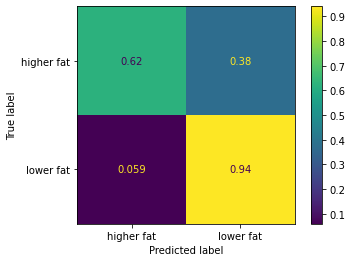

In [31]:
cmatrix = plot_confusion_matrix(best_rfc, X_test, y_test, normalize="true")

Figure 4: Confusion matrix depicting the proportion of true positives, true negatives, false positives, and false negatives

The proportions of true positives, true negatives, false positives, and false negatives are as follows:
- True positives: 0.94
- True negatives: 0.62
- False positives: 0.38
- False negatives: 0.059


\
Then, I use sklearn's `classification_report` to return the F1-score of the model on the test set

In [32]:
print(
    classification_report(
        y_test, best_rfc.predict(X_test), target_names=["negative", "positive"]
    )
)

              precision    recall  f1-score   support

    negative       0.85      0.62      0.72        72
    positive       0.82      0.94      0.88       135

    accuracy                           0.83       207
   macro avg       0.84      0.78      0.80       207
weighted avg       0.83      0.83      0.82       207



The sample-weighted F1-score of the final model is **0.82**

## Writing
For initially exploring models, I chose to try a random forest classification model, a k neighbors classification model, and a support vector classification model. These models were selected for their suitability for binary classification and the size of the data set. At a glance, the data exhibited some class imbalance, which suggested the random forest classifier may have been the best choice due to its robustness to imbalance; however the unbalanced model appeared to perform better than its balanced counterpart. As the data set is relatively small and free of large outliers, the k neighbors clasifier was well suited; whereas with a larger dataset it may well have been too resource-intensive, and with large outliers may have been too sensitive.

From initial evaluation and comparison of training scores, the random forest classifier appeared the best fit with a score of ~0.853, followed by the k neighbors clasifier scoring ~0.841, and lastly the support vector classifier with ~0.810. The reasons for the random forest classifier's better performance could be attributed to it's class imbalance-robustness mentioned, or to the nature of the model, in the sense that it is an ensemble learning rather than individual. 

# Discussion
The goal of this project was to build a supervised machine learning model with the ability to classifiy a given cheese as lower-fat or higher-fat, knowing the milk type and moisture content. The expected outcome was that the model would accurately classify cheeses as either lower-fat or higher-fat. The outcome was as initially expected, as given the resulting F1-score (0.82), it appears the model can in fact discriminate between the two classes of cheese. This suggests that this model could be helpful to those in the cheese industry with respect to efficiently and correctly categorizing and/or labeling cheeses, which would prove a valuable business tool to streamline distribution, improve marketing strategies and better catering to consumers.

The model used may be limited by the small number of features used. There are a number more available, which could be incorporated to potentially yield a better model with a better ability to discriminate. For example, if features such as rind type, manufacturing type, or category/type are included, the model may be able to even better discriminate between cheese categories. 

There are a number of potential sources of bias that may affect the results of this project. For one, sampling bias may be at play if the dataset does not represent the entire population of cheeses and cheese makers in Canada. For example, if there are many artisan or small cheese producers that produce unique types of cheese and are not included, the model may not perform as expected if tested on this subset of the population. Alternatively, there may be selection bias if, for example, the dataset contains a disproportionately low amount of cheeses made from goat milk, then the model will be biased towards cheeses made from other types of milk. 

## References
- Data Source ( *canadianCheeseDirectory.csv* )
    - The dataset was originally obtained from The Government of Canada's Open Government Portal; however was provided by the course instructors as it is no longer available at that location
- [Pandas](https://pandas.pydata.org/docs/)
    - A python library for data structures and data analysis tools
- [Altair](https://altair-viz.github.io/)
    - A python library for data visualization
- [scikit-learn](https://scikit-learn.org/stable/)
    - A python library for predictive data analysis

